## Imports

In [2]:
import dill
import csv
import unicodedata
import re
import Orange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import ones,vstack
from numpy.linalg import lstsq 
from orangecontrib.associate.fpgrowth import *

pd.options.display.max_colwidth = 100

In [ ]:
dill.dump_session('saveNotebook_env.db')
#dill.load_session('saveNotebook_env.db')

## Funções auxiliares.. limpar dados, etc
- Remover acentos
- Normalizar string
- Encontrar ids em strings
- Criar basket
- Exportar basket como .basket

In [3]:
#_______________________________________________________________________________
# remove accentes in an unicode string
def remove_accents( aString, encoding='utf-8' ):
    #next instruction is not necessary in Python3
    #aString_unicode = to_unicode( aString, encoding )
    aString_unicode = aString
    nfkd_form = unicodedata.normalize( 'NFKD', aString_unicode )
    only_ascii_form = nfkd_form.encode( 'ascii', 'ignore' ).decode( encoding )
    return only_ascii_form


#_______________________________________________________________________________
# define the "normalize" process that applies to each string
def normalizeString( aString ):
    # substitute "=" symbol because it is used in the basket format
    symbolToReplace = "="
    #symbolNew = "|" #this substitution does not work in Orange3
    symbolNew = "+"
    aString = aString.replace( symbolToReplace, symbolNew )
    
    # eliminate spaces (white characters)
    symbolToReplace = " "
    symbolNew = ""
    aString = aString.replace( symbolToReplace, symbolNew )

    # eliminate quotes (" character)
    symbolToReplace = "\""
    symbolNew = "$"
    aString = aString.replace( symbolToReplace, symbolNew )
    
    # eliminate accent characters
    encoding_windows = "iso-8859-1" #"cp1252" #"latin-1" #"latin9" 
    aString = remove_accents( aString, encoding_windows )
    
    # to lower
    aString = aString.lower()
 
    return aString
#______________________________________________________________________________
# seleciona os ids da string q receber
def findId(string):
    #print(">>", string)
    regx = re.compile(r'\b(([a-z]{3}\_[0-9]{4}))\b')
    string = regx.findall(string)
    #print(">>>", string)
    return string[0][0]

#______________________________________________________________________________
# Criar um basket através do dataframe recebido
def createBasket(dataframe):
    basket = {}
    #with open( fileNameIN, 'rb' ) as f:
    for row in range(dataframe.shape[0]):

        transactionID = dataframe['Transaction'].iloc[row]
        if transactionID not in basket.keys():
            basket[ transactionID ] = {}

        itemID = dataframe['Product'].iloc[row]
        if itemID not in basket[ transactionID ].keys():
            basket[ transactionID ][ itemID ] = 0
            
        basket[ transactionID ][ itemID ] += 1
        
        #print(basket[transactionID])
            
    return basket

#______________________________________________________________________________
# Gerar um ficheiro basket
def generateDataFile( basket, fileNameOUT ):
    with open ( fileNameOUT, mode='wt', encoding='utf-8' ) as f:
        for transactionID in basket.keys():
            line = ', '.join("{!s}={!r}".format(key,val) for (key,val) in basket[transactionID].items())
            f.write( line + '\n' )

## Funções auxiliares para:
- Encontrar melhores regras com x criterios
- Melhores regras com base em thresholds
- Print regras associadas a um conjunto
- Print todas as melhores combinacoes encontradas e as suas regras
- Fazer equacao reta
- Encontrar pontos com maior suporte e maior confiança (meio da curva)
- contar produtos

In [4]:
#Encontrar as melhores regras para os criterios passados
def optimalThresholds(fName, minSupp, maxSupp, incSupp, minConf, maxConf, incConf, maxRules):
    
    Xbasket = Orange.data.Table(fName)
    # make the OneHot transform in order to apply the "associate" methods

    dfMBA = pd.DataFrame(columns=['Support', 'Confidence', 'NumberOfRules'])  

    dfIndex = 0
    for support in np.arange(minSupp, maxSupp, incSupp):
        support = round(support, 3)
        print("Support:", support)
        
        rulesLastIteration = 0
        for confidence in np.arange(minConf, maxConf, incConf):
            confidence = round(confidence, 3)
            #print("Confidence:", confidence)
            X, mapping = OneHot.encode( Xbasket )
            setOf_itemset = frequent_itemsets( X, support )
            dict_setOf_itemset = dict( setOf_itemset )
            setOf_rule = association_rules( dict_setOf_itemset, confidence )
            list_setOf_rule = list( setOf_rule )
            #if(len(list_setOf_rule) != 0 and len(list_setOf_rule) <= maxRules and rulesLastIteration != len(list_setOf_rule)):
            if(len(list_setOf_rule) != 0 and len(list_setOf_rule) <= maxRules):
                dfMBA.loc[dfIndex] = [support, confidence, len(list_setOf_rule)]
                dfIndex += 1
            
            rulesLastIteration = len(list_setOf_rule)
            #Se já não está a encontrar nada break
            if(len(list_setOf_rule) == 0 ): 
                break
       
    return dfMBA
    
# Selecionar as regras mais adequadas aos thresholds escolhidos, return dataframe
def selecionarMelhores(dataframe, maxRegrasSuporteAlto, maxRegrasConfiancaAlta, confStep, suppStep):

    #supp = dataframe['Support']    #x
    #conf = dataframe['Confidence'] #y
    #plt.plot(supp, conf, 'o')
    
    #Escolher os com mais suporte e menos confiança, começar confiança em baixo e incrementar
    nrRegrasSuporteAlto = 0
    confThreshold = 0.0
    regrasSuporteAlto = pd.DataFrame(columns=['Support', 'Confidence', 'NumberOfRules'])
    while(nrRegrasSuporteAlto < maxRegrasSuporteAlto):
        regrasSuporteAlto = dataframe[dataframe['Confidence'] <= confThreshold]
        nrRegrasSuporteAlto = regrasSuporteAlto['NumberOfRules'].sum()
        confThreshold += confStep
            
    #Escolher os com menos suporte e mais confiança, começar suporte em 0 e incrementar
    nrRegrasConfiancaAlta = 0
    suppThreshold = 0.0
    regrasConfiancaAlta = pd.DataFrame(columns=['Support', 'Confidence', 'NumberOfRules'])
    while(nrRegrasConfiancaAlta < maxRegrasConfiancaAlta):
        regrasConfiancaAlta = dataframe[dataframe['Support'] <= suppThreshold]
        nrRegrasConfiancaAlta = regrasConfiancaAlta['NumberOfRules'].sum()
        suppThreshold += suppStep
        
    return pd.concat([regrasSuporteAlto, regrasConfiancaAlta]), suppThreshold, confThreshold
    

def equacaoReta(minX, minY, maxX, maxY):
    print("minX", minX)
    print("minY", minY)
    print("maxX", maxX)
    print("maxY", maxY)
    points = [(minX,minY),(maxX,maxY)]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, b = lstsq(A, y_coords)[0]
    print("Line Solution is y = {m}x + {b}".format(m=m,b=b))
    return m, b
    

def selecionarHighConfHighSupp(dataframe, maxRegras):
    
    minX = dataframe['Support'].min()
    minY = dataframe['Confidence'].min()
    maxX = dataframe['Support'].max()
    maxY = dataframe['Confidence'].max()
    
    m, b = equacaoReta(minX, minY, maxX, maxY)
    
    x = np.linspace(0, maxX, 1000)
    
    regrasConfiancaAlta = pd.DataFrame(columns=['Support', 'Confidence', 'NumberOfRules'])
    steps = np.arange(0, 3, 0.01)
    axes = plt.gca()
    axes.set_xlim((0., maxX))
    axes.set_ylim((0., maxY))
    
    for i in steps:
        regrasConfiancaAlta = regrasConfiancaAlta.iloc[0:0] #clear df
        dfIndex = 0
        for row in range(dataframe.shape[0]):
            plt.plot(x, m*x + (i+b), color='g')
            plt.plot(x, m*x - (i+b), color='b')
            supp = dataframe['Support'].iloc[row]    #x
            conf = dataframe['Confidence'].iloc[row] #y
            rules = dataframe['NumberOfRules'].iloc[row] #y
            a = conf - (supp * m) 
            plt.plot(supp, conf, 'o')
            if( -(i+b) < a and a < (i+b)):
                
                print("Encontrei uma dentro da reta! >", supp, ", ", conf, ", ", rules)
                regrasConfiancaAlta.loc[dfIndex] = [supp, conf, rules]
                dfIndex += 1
        
        plt.show()  
        if(regrasConfiancaAlta['NumberOfRules'].sum() > maxRegras):
            break
    
    return regrasConfiancaAlta
    
    
    


#Print regras associadas a um conjunto (suporte, confiança), void
def printRules(fName, support, confidence, bolFreqItemsets):
    Xbasket = Orange.data.Table(fName)
        
    X, mapping = OneHot.encode( Xbasket )

    #support = 0.08
    setOf_itemset = frequent_itemsets( X, support )

    #confidence = 0.05
    setOf_itemset = frequent_itemsets( X, support )
    # the next line "consumes" all the "setOf_itemset" and builds a dictionary from it
    # (this way we can use it for future operations)
    dict_setOf_itemset = dict( setOf_itemset )
    setOf_rule = association_rules( dict_setOf_itemset, confidence )
    
    setOf_rule = association_rules( dict_setOf_itemset, confidence )
    list_setOf_rule = list( setOf_rule )
    
    for itemset in dict_setOf_itemset.keys():
       supp = dict_setOf_itemset[itemset]
       decoded_itemset = [ var.name for _, var, _ in OneHot.decode( itemset, Xbasket, mapping ) ]
       tuple_itemset = ( decoded_itemset, supp )
       #print( tuple_itemset )
       
    if(bolFreqItemsets):  
        print()
        print( "Frequent itemsets:" )
        for itemset in dict_setOf_itemset.keys():
           supp = dict_setOf_itemset[itemset]
           decoded_itemset = [ var.name for _, var, _ in OneHot.decode( itemset, Xbasket, mapping ) ]
           tuple_itemset = ( decoded_itemset, supp )
           print( tuple_itemset )

    if(len(list_setOf_rule)):
        print( "Rules (support = ", support , ", confidence = ", confidence, ", rules = ", len(list_setOf_rule) ,")")
        print("LHS | RHS | Support | Confidence")
        for rule in list_setOf_rule:
           LHS, RHS, supp, conf = rule
           decoded_LHS = [ var.name for _, var, _ in OneHot.decode( LHS, Xbasket, mapping ) ]
           decoded_RHS = [ var.name for _, var, _ in OneHot.decode( RHS, Xbasket, mapping ) ]
           tuple_rule = ( decoded_LHS, decoded_RHS, supp, conf )
           print( tuple_rule )
    
#Print todas as melhores combinacoes encontradas e as suas regras
def showRules(dataframe, fName):
    
    for row in range(dataframe.shape[0]):
    #for row in dfTransProd:
        supp = dataframe['Support'].iloc[row]
        conf = dataframe['Confidence'].iloc[row]
        printRules(fName, supp, conf, False)
        
#Contar produtos pelo id
def dataframeProductCount(dfExp, columnName):
    productTags = set()
    
    for i in dfExp[columnName]:
        newList = i.split("*")
        if(len(newList)>1):
            for it in newList:
                auxItemList = it.split("_")
                if(len(auxItemList) == 2 and len(it) == 8):
                    productTags.add(it)
        else:
            auxItemList = i.split("_")
            if(len(auxItemList) == 2 and len(i) == 8):
                productTags.add(i)
                
    #Initialize dataframe product_id count
    dfPidCount = pd.DataFrame(columns=['ProductID', 'Count'])
    
    indexDF = 0
    for tags in productTags:
        dfPidCount.loc[indexDF] = [tags, 0]
        indexDF += 1
      
             
    
    #Count how many ocorrunces of each product
    pIndex = 0
    for pID in dfPidCount['ProductID']:
        countPID = 0
        for product in dfExp[columnName]:
            if(pID in product):
                countPID += 1
                
        dfPidCount.loc[pIndex] = [pID, countPID]
        pIndex += 1
    
    return dfPidCount

#Contar produtos geral
def dataframeCount(dfExp, columnName):
    productTags = set()
    
    for i in dfExp[columnName]:
        productTags.add(i)
                
    #Initialize dataframe product_id count
    dfPidCount = pd.DataFrame(columns=['ProductID', 'Count'])
    
    indexDF = 0
    for tags in productTags:
        dfPidCount.loc[indexDF] = [tags, 0]
        indexDF += 1
    
    #Count how many ocorrunces of each product
    pIndex = 0
    for pID in dfPidCount['ProductID']:
        countPID = 0
        for product in dfExp[columnName]:
            if(pID in product):
                countPID += 1
                
        dfPidCount.loc[pIndex] = [pID, countPID]
        pIndex += 1
    
    return dfPidCount

In [4]:
df = pd.read_csv('z_dataset_JAN.csv')

## Análise de dados dataset original

In [5]:
dfProdutos1 = df[['product_gui']].copy()
dfProdutos1 = dfProdutos1.dropna() 
dfProdutos1['product_gui'] = dfProdutos1['product_gui'].apply(normalizeString)
dfProdutosSomas1 = dataframeCount(dfProdutos1, 'product_gui')


### Visualização dados gerais sem cortes pelos ids

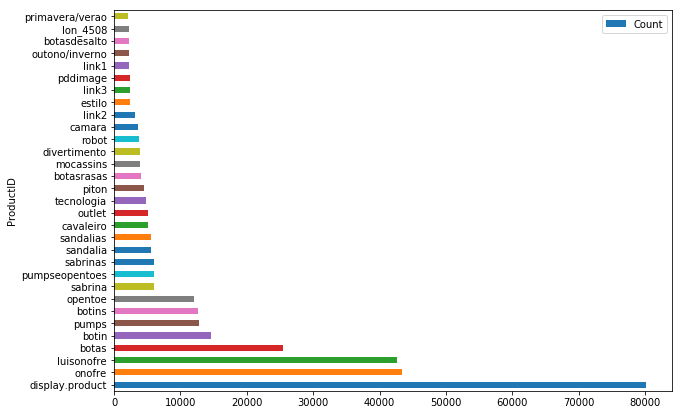

In [6]:
#dfProdutosSomas1.sort_values(by=['Count'], ascending=False).head(50)
#dfProdutosSomas[(dfProdutosSomas['ProductID'].str.len() > 4) & (dfProdutosSomas['ProductID'].str.len() <= 15)].sort_values(by=['Count'], ascending=False).head(31)
#dfProdutosSomas1.sort_values(by=['Count'], ascending=False).head(15).plot.barh(x='ProductID', y='Count', rot=0, figsize=(10,5))
dfProdutosSomas1[(dfProdutosSomas1['ProductID'].str.len() > 4) & (dfProdutosSomas1['ProductID'].str.len() <= 15)].sort_values(by=['Count'], ascending=False).head(31).plot.barh(x='ProductID', y='Count', rot=0, figsize=(10,7))

### Visualização dados gerais, para elementos com id unico

C:\Users\lyona\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


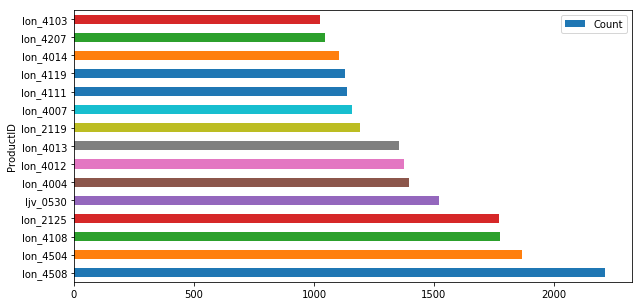

In [7]:
dfProdutos2 = df[['product_gui']].copy()
dfProdutos2 = dfProdutos2.dropna() 
dfProdutos2 = dfProdutos2[dfProdutos2['product_gui'].str.contains(r'\b(([a-z]{3}\_[0-9]{4}))\b', regex=True)]
dfProdutos2['product_gui'] = dfProdutos2['product_gui'].apply(normalizeString)
dfProdutos2['product_gui'] = dfProdutos2['product_gui'].apply(findId)
dfProdutosSomas2 = dataframeProductCount(dfProdutos2, 'product_gui')

dfProdutosSomas2.sort_values(by=['Count'], ascending=False).head(15).plot.barh(x='ProductID', y='Count', rot=0, figsize=(10,5))

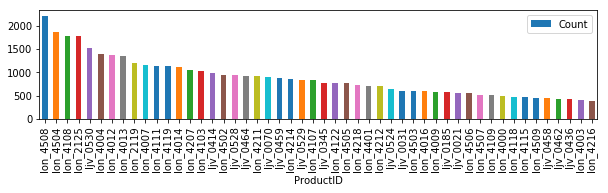

In [9]:
dfProdutosSomas2.sort_values(by=['Count'], ascending=False).head(50).plot.bar(x='ProductID', y='Count', rot=90, figsize=(10,2))

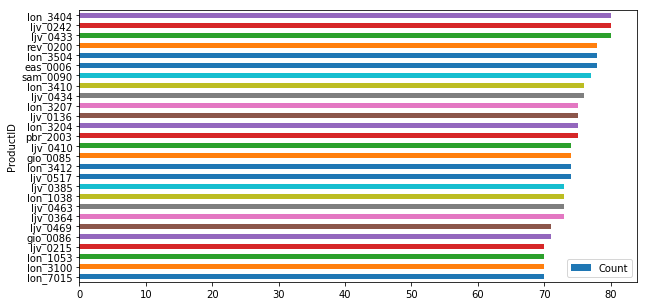

In [16]:
dfProdutosSomas2[(dfProdutosSomas2['Count']>=70) & (dfProdutosSomas2['Count']<=80)].sort_values(by=['Count']).plot.barh(x='ProductID', y='Count', rot=0, figsize=(10,5))

## Processo de criação do basket apartir do csv

In [17]:
listaPossiveisTID = ['session_id', 'cookie_id']
TID = listaPossiveisTID[0]
#Criar a tabela TID | PID
dfSessionProduct = df[[TID, 'product_gui']]
#Remover NaN values
dfSessionProduct = dfSessionProduct.dropna() 
#Escolher session_id's com 5 a 30 sessões registadas
dfSessionProduct = dfSessionProduct[(dfSessionProduct.groupby(TID)[TID].transform('size') > 3) 
                                    & (dfSessionProduct.groupby(TID)[TID].transform('size') < 30)]
#Normalizar as strings produto
dfSessionProduct['product_gui'] = dfSessionProduct['product_gui'].apply(normalizeString)
#Escolher agora strings com identificador AAA_0000
dfSessionProduct = dfSessionProduct[dfSessionProduct['product_gui'].str.contains(r'\b(([a-z]{3}\_[0-9]{4}))\b', regex=True)]
#print(dfSessionProduct[dfSessionProduct['product_gui'].str.contains("lon_4004")])
#Trocar links, etc só por ids
dfSessionProduct['product_gui'] = dfSessionProduct['product_gui'].apply(findId)
#Alterar nomes das colunas para transaction e product
dfSessionProduct.columns = ['Transaction', 'Product']
#Criar o basket
basket = createBasket(dfSessionProduct)
#Exportar o basket como .basket
generateDataFile(basket, "session5to30TID.basket")

C:\Users\lyona\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


Market Basket Analysis - dataExploration.basket

Support: 0.005
Support: 0.01
Support: 0.015
Support: 0.02
Support: 0.025
Support: 0.03
Support: 0.035
Support: 0.04
Support: 0.045
Support: 0.05
Support: 0.055
Support: 0.06
Support: 0.065
Support: 0.07
Support: 0.075
Support: 0.08
Support: 0.085
Support: 0.09
Support: 0.095
Support: 0.1
Support: 0.105
Support: 0.11
Support: 0.115
Support: 0.12
Support: 0.125
Support: 0.13
Support: 0.135
Support: 0.14
Support: 0.145
Support: 0.15
Support: 0.155
Support: 0.16
Support: 0.165
Support: 0.17
Support: 0.175
Support: 0.18
Support: 0.185
Support: 0.19
Support: 0.195
Support: 0.2
Support: 0.205
Support: 0.21
Support: 0.215
Support: 0.22
Support: 0.225
Support: 0.23
Support: 0.235
Support: 0.24
Support: 0.245
Support: 0.25
Support: 0.255
Support: 0.26
Support: 0.265
Support: 0.27
Support: 0.275
Support: 0.28
Support: 0.285
Support: 0.29
Support: 0.295
Support: 0.3
Support: 0.305
Support: 0.31
Support: 0.315
Support: 0.32
Support: 0.325
Support: 0.33
Support: 0.335
Support: 0.34
Support: 0.345
Su

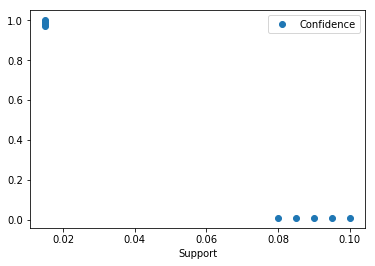

In [21]:
maxRules =  15
dfThresholds = optimalThresholds("dataExploration.basket", 0.005, 1.005, 0.005, 0.01, 1.01, 0.01, maxRules)

#dfThresholds.plot(x='Support', y='Confidence', style='o')    

#dfThresholds['SumSuppConf'] = dfThresholds['Support'] + dfThresholds['Confidence']
        
melhoresRegrasAuto, suppThesh, suppConf = selecionarMelhores(dfThresholds, maxRules, maxRules, 0.01, 0.005)
melhoresRegrasAuto.plot(x='Support', y='Confidence', style='o')
print("Melhore valores de suporte e confiança: ")
print(melhoresRegrasAuto)

# Escolher o melhor dos extremos
# newDF3 = newDF2[((newDF2['Confidence'] > 0.950) & (newDF2['Support'] < 0.03)) | ((newDF2['Confidence'] < 0.850) & (newDF2['Support'] > 0.065))] 
    
#dfThresholds[(dfThresholds['NumberOfRules']>0) & (dfThresholds['NumberOfRules'] <= maxRules)].sort_values(by=['NumberOfRules'])
# dfThresholds[(dfThresholds['NumberOfRules'] >= 4) & (dfThresholds['NumberOfRules'] < 13)].sort_values(by=['Support']) 

showRules(melhoresRegrasAuto, "dataExploration.basket")

minX 0.015
minY 0.01
maxX 0.1
maxY 1.0
Line Solution is y = 11.647058823529408x + -0.16470588235294117


C:\Users\lyona\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


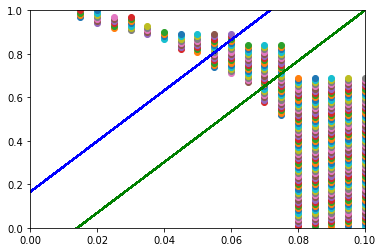

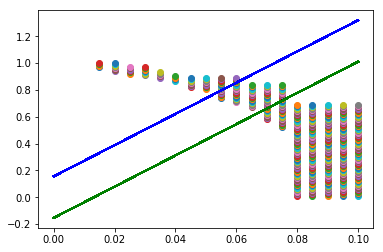

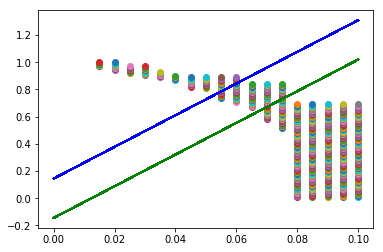

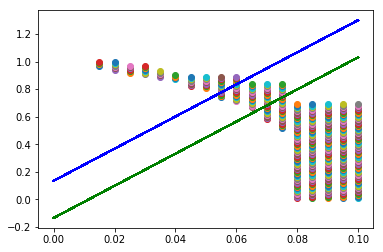

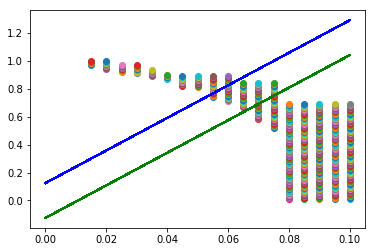

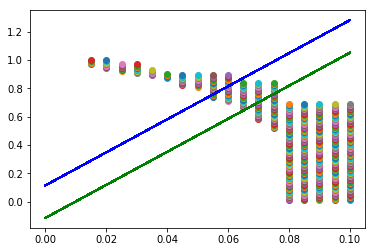

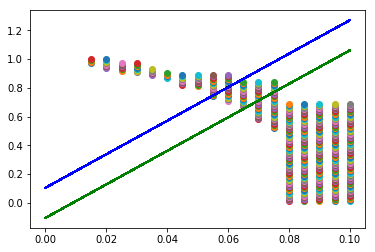

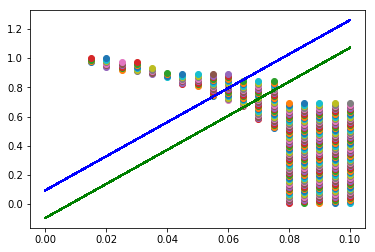

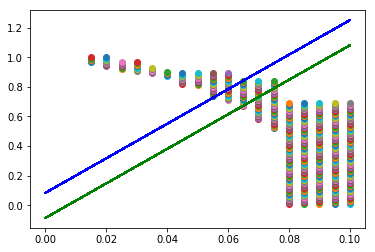

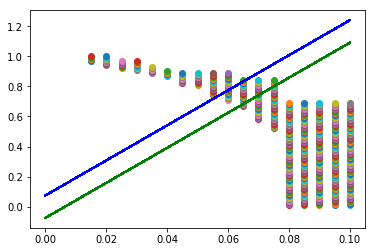

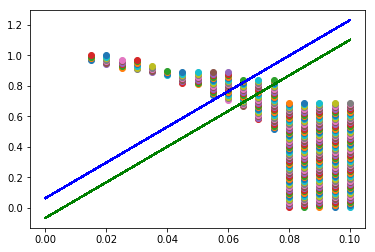

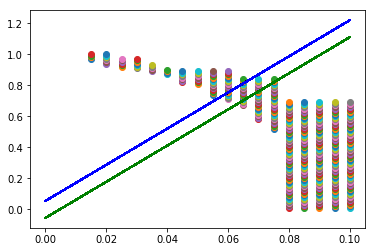

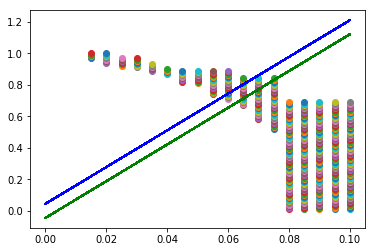

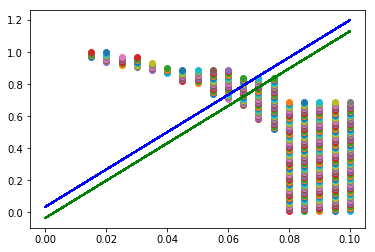

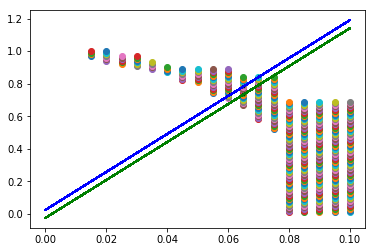

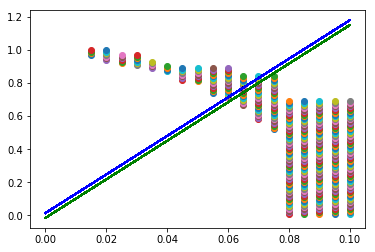

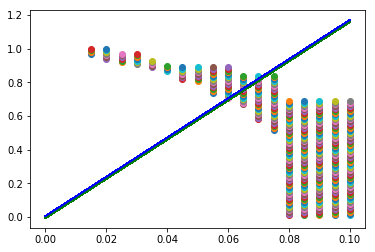

Encontrei uma dentro da reta! > 0.065 ,  0.76 ,  7.0
Encontrei uma dentro da reta! > 0.07 ,  0.81 ,  2.0
Encontrei uma dentro da reta! > 0.07 ,  0.82 ,  2.0


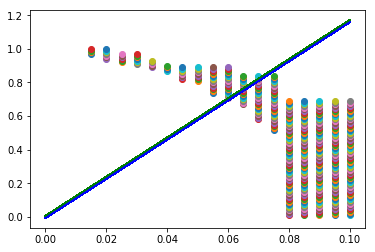

Encontrei uma dentro da reta! > 0.06 ,  0.71 ,  15.0
Encontrei uma dentro da reta! > 0.065 ,  0.75 ,  8.0
Encontrei uma dentro da reta! > 0.065 ,  0.76 ,  7.0
Encontrei uma dentro da reta! > 0.065 ,  0.77 ,  6.0
Encontrei uma dentro da reta! > 0.07 ,  0.8 ,  3.0
Encontrei uma dentro da reta! > 0.07 ,  0.81 ,  2.0
Encontrei uma dentro da reta! > 0.07 ,  0.82 ,  2.0
Encontrei uma dentro da reta! > 0.07 ,  0.83 ,  1.0


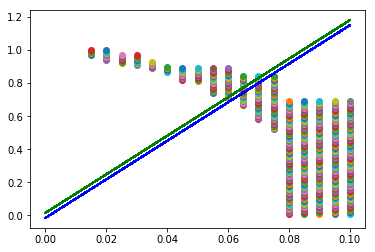

,Support,Confidence,NumberOfRules
0,0.060,0.71,15.0
1,0.065,0.75,8.0
2,0.065,0.76,7.0
3,0.065,0.77,6.0
4,0.070,0.80,3.0
5,0.070,0.81,2.0
6,0.070,0.82,2.0
7,0.070,0.83,1.0


In [22]:
middleValues = selecionarHighConfHighSupp(dfThresholds, maxRules)
middleValues

# MBA - dataExploration.basket

Support: 0.005
Support: 0.01
Support: 0.015
Support: 0.02
Support: 0.025
Support: 0.03
Support: 0.035
Support: 0.04
Support: 0.045
Support: 0.05
Support: 0.055
Support: 0.06
Support: 0.065
Support: 0.07
Support: 0.075
Support: 0.08
Support: 0.085
Support: 0.09
Support: 0.095


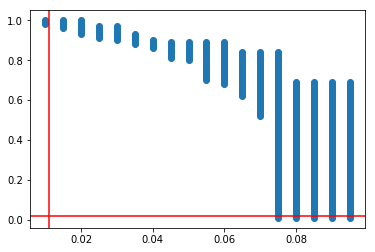

Melhore valores de suporte e confiança: 
     Support  Confidence  NumberOfRules
159    0.075        0.01           18.0
243    0.080        0.01           12.0
312    0.085        0.01           10.0
381    0.090        0.01            8.0
450    0.095        0.01            4.0
0      0.010        0.98           20.0
1      0.010        0.99           20.0
2      0.010        1.00           20.0
Rules (support =  0.075 , confidence =  0.01 , rules =  18 )
LHS | RHS | Support | Confidence
(['lon_4504', 'lon_4508'], ['lon_2125'], 85, 0.7391304347826086)
(['lon_4504'], ['lon_2125', 'lon_4508'], 85, 0.47752808988764045)
(['lon_2125', 'lon_4508'], ['lon_4504'], 85, 0.7456140350877193)
(['lon_4508'], ['lon_2125', 'lon_4504'], 85, 0.45698924731182794)
(['lon_2125'], ['lon_4504', 'lon_4508'], 85, 0.5182926829268293)
(['lon_2125', 'lon_4504'], ['lon_4508'], 85, 0.8415841584158416)
(['lon_4004'], ['lon_4508'], 101, 0.6158536585365854)
(['lon_4508'], ['lon_4004'], 101, 0.543010752688172)
(['lon

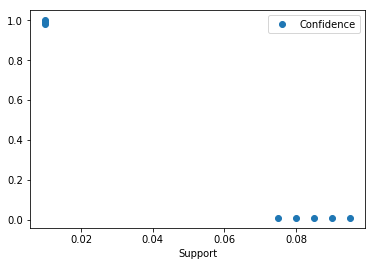

In [7]:
maxRules =  20
dfThresholdsCookies = optimalThresholds("dataExploration.basket", 0.005, 0.1, 0.005, 0.01, 1.01, 0.01, maxRules)

#dfThresholds.plot(x='Support', y='Confidence', style='o')    
        
melhoresRegrasAuto, suppThreshold, confThreshold = selecionarMelhores(dfThresholdsCookies, maxRules, maxRules, 0.01, 0.001)

#___
supp = dfThresholdsCookies['Support']    #x
conf = dfThresholdsCookies['Confidence'] #y

plt.plot(supp, conf, 'o')
plt.axvline(x = suppThreshold, color='red')
plt.axhline(y = confThreshold, color='red')
plt.show()

#___

melhoresRegrasAuto.plot(x='Support', y='Confidence', style='o')
print("Melhore valores de suporte e confiança: ")
print(melhoresRegrasAuto)


showRules(melhoresRegrasAuto, "dataExploration.basket")

minX 0.01
minY 0.01
maxX 0.095
maxY 1.0


C:\Users\lyona\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Line Solution is y = 11.647058823529411x + -0.10647058823529384


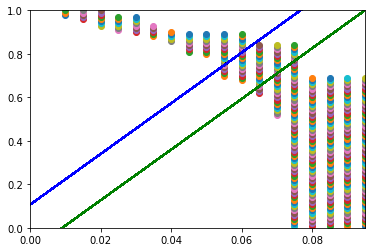

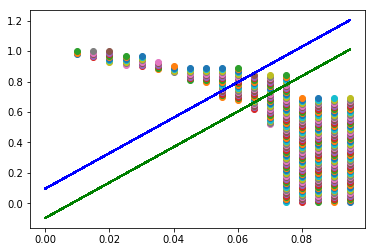

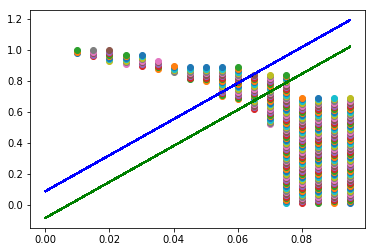

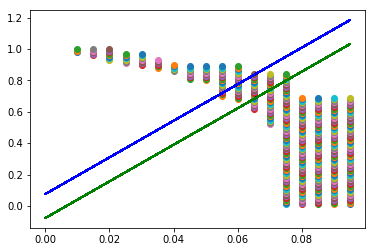

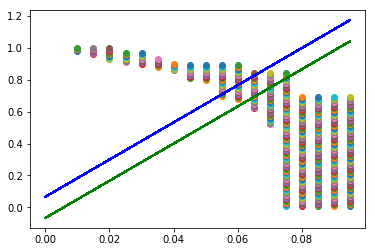

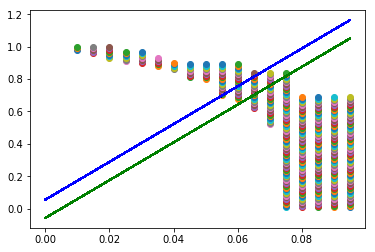

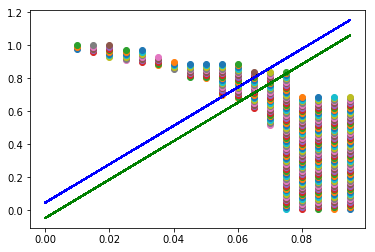

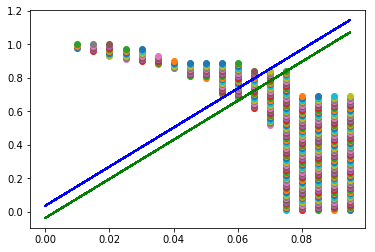

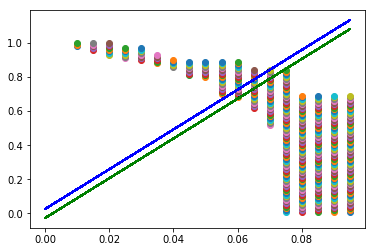

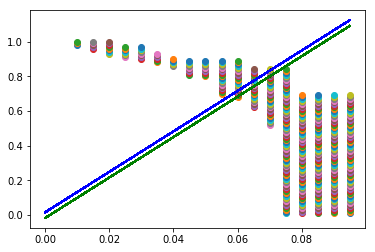

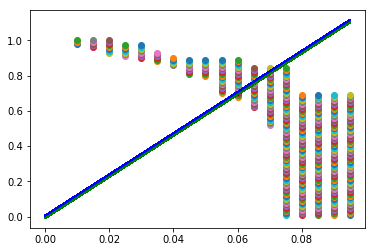

Encontrei uma dentro da reta! > 0.06 ,  0.7 ,  16.0
Encontrei uma dentro da reta! > 0.065 ,  0.76 ,  7.0


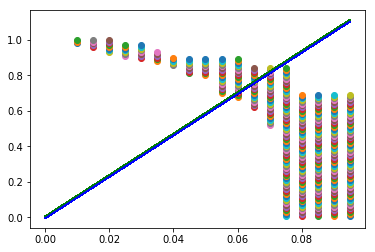

,Support,Confidence,NumberOfRules
0,0.060,0.70,16.0
1,0.065,0.76,7.0


In [8]:
middleValuesCookies = selecionarHighConfHighSupp(dfThresholdsCookies, maxRules)
middleValuesCookies

# MBA - session5to30TID.basket

Support: 0.001
Support: 0.002
Support: 0.002
Support: 0.002
Support: 0.003
Support: 0.004
Support: 0.004
Support: 0.005
Support: 0.005
Support: 0.006
Support: 0.006
Support: 0.006
Support: 0.007
Support: 0.008
Support: 0.008
Support: 0.008
Support: 0.009
Support: 0.01


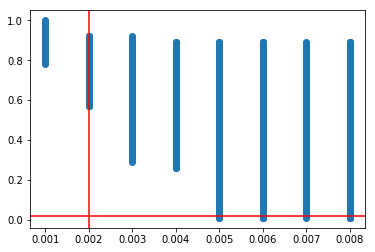

Melhores valores de suporte e confiança: 
      Support  Confidence  NumberOfRules
323     0.005        0.01           12.0
412     0.005        0.01           12.0
501     0.006        0.01            8.0
590     0.006        0.01            8.0
679     0.006        0.01            8.0
768     0.007        0.01            2.0
857     0.008        0.01            2.0
946     0.008        0.01            2.0
1035    0.008        0.01            2.0
0       0.001        0.78           15.0
1       0.001        0.79           15.0
2       0.001        0.80           15.0
3       0.001        0.81           15.0
4       0.001        0.82           15.0
5       0.001        0.83           15.0
6       0.001        0.84           15.0
7       0.001        0.85           15.0
8       0.001        0.86           15.0
9       0.001        0.87           15.0
10      0.001        0.88           11.0
11      0.001        0.89            9.0
12      0.001        0.90            8.0
13      0.001  

Rules (support =  0.001 , confidence =  0.82 , rules =  15 )
LHS | RHS | Support | Confidence
(['lon_4212', 'lon_4211', 'lon_4214'], ['lon_4216'], 7, 0.875)
(['ljv_0237', 'ljv_0109', 'ljv_0242'], ['ljv_0530'], 8, 1.0)
(['lon_4508', 'lon_4109'], ['lon_4107'], 10, 0.9090909090909091)
(['ljv_0237', 'ljv_0242'], ['ljv_0530'], 13, 1.0)
(['ljv_0346', 'ljv_0348'], ['ljv_0347'], 14, 0.875)
(['ljv_0109', 'ljv_0242'], ['ljv_0530'], 12, 1.0)
(['ljv_0237', 'ljv_0109'], ['ljv_0530'], 13, 1.0)
(['ljv_0264', 'ljv_0257'], ['ljv_0256'], 8, 1.0)
(['ljv_0264', 'ljv_0256'], ['ljv_0257'], 8, 0.8888888888888888)
(['ljv_0237'], ['ljv_0530'], 58, 0.8923076923076924)
(['ljv_0242'], ['ljv_0530'], 34, 0.8717948717948718)
(['ljv_0109'], ['ljv_0530'], 23, 0.92)
(['eas_0007'], ['eas_0005'], 11, 0.9166666666666666)
(['eas_0004'], ['eas_0005'], 8, 0.8888888888888888)
(['ljv_0056'], ['ljv_0022'], 7, 0.875)
Rules (support =  0.001 , confidence =  0.83 , rules =  15 )
LHS | RHS | Support | Confidence
(['lon_4212', 'lon_

Rules (support =  0.001 , confidence =  0.95 , rules =  5 )
LHS | RHS | Support | Confidence
(['ljv_0237', 'ljv_0109', 'ljv_0242'], ['ljv_0530'], 8, 1.0)
(['ljv_0237', 'ljv_0242'], ['ljv_0530'], 13, 1.0)
(['ljv_0109', 'ljv_0242'], ['ljv_0530'], 12, 1.0)
(['ljv_0237', 'ljv_0109'], ['ljv_0530'], 13, 1.0)
(['ljv_0264', 'ljv_0257'], ['ljv_0256'], 8, 1.0)
Rules (support =  0.001 , confidence =  0.96 , rules =  5 )
LHS | RHS | Support | Confidence
(['ljv_0237', 'ljv_0109', 'ljv_0242'], ['ljv_0530'], 8, 1.0)
(['ljv_0237', 'ljv_0242'], ['ljv_0530'], 13, 1.0)
(['ljv_0109', 'ljv_0242'], ['ljv_0530'], 12, 1.0)
(['ljv_0237', 'ljv_0109'], ['ljv_0530'], 13, 1.0)
(['ljv_0264', 'ljv_0257'], ['ljv_0256'], 8, 1.0)
Rules (support =  0.001 , confidence =  0.97 , rules =  5 )
LHS | RHS | Support | Confidence
(['ljv_0237', 'ljv_0109', 'ljv_0242'], ['ljv_0530'], 8, 1.0)
(['ljv_0237', 'ljv_0242'], ['ljv_0530'], 13, 1.0)
(['ljv_0109', 'ljv_0242'], ['ljv_0530'], 12, 1.0)
(['ljv_0237', 'ljv_0109'], ['ljv_0530'],

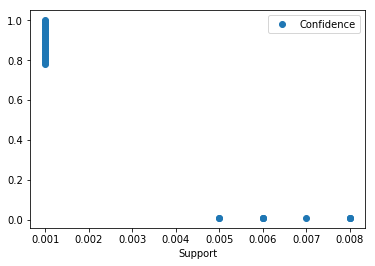

In [9]:
maxRules =  15
dfThresholdsSessions = optimalThresholds("session5to30TID.basket", 0.001, 0.010, 0.0005, 0.01, 1.01, 0.01, maxRules)

#dfThresholds.plot(x='Support', y='Confidence', style='o')    

#dfThresholds['SumSuppConf'] = dfThresholds['Support'] + dfThresholds['Confidence']
        
melhoresRegrasAuto, suppThreshold, confThreshold = selecionarMelhores(dfThresholdsSessions, maxRules, maxRules, 0.01, 0.001)

supp = dfThresholdsSessions['Support']    #x
conf = dfThresholdsSessions['Confidence'] #y

plt.plot(supp, conf, 'o')
plt.axvline(x = suppThreshold, color='r')
plt.axhline(y = confThreshold, color='r')
plt.show()

melhoresRegrasAuto.plot(x='Support', y='Confidence', style='o')
print("Melhores valores de suporte e confiança: ")
print(melhoresRegrasAuto)

# Escolher o melhor dos extremos
# newDF3 = newDF2[((newDF2['Confidence'] > 0.950) & (newDF2['Support'] < 0.03)) | ((newDF2['Confidence'] < 0.850) & (newDF2['Support'] > 0.065))] 
    
#dfThresholds[(dfThresholds['NumberOfRules']>0) & (dfThresholds['NumberOfRules'] <= maxRules)].sort_values(by=['NumberOfRules'])
# dfThresholds[(dfThresholds['NumberOfRules'] >= 4) & (dfThresholds['NumberOfRules'] < 13)].sort_values(by=['Support']) 

showRules(melhoresRegrasAuto, "session5to30TID.basket")

minX 0.001
minY 0.01
maxX 0.008
maxY 1.0
Line Solution is y = 141.42857142857147x + -0.13142857142857134


C:\Users\lyona\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


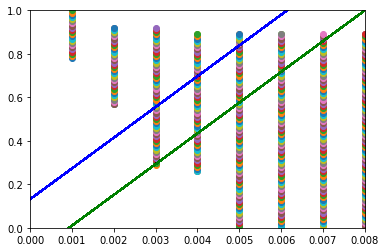

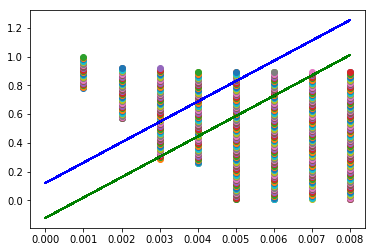

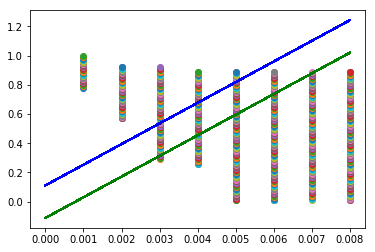

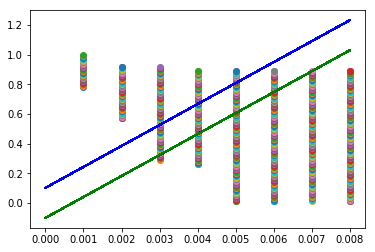

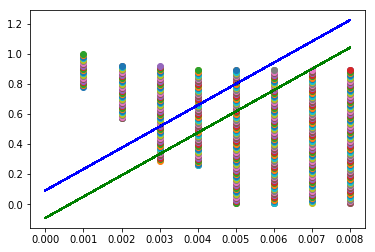

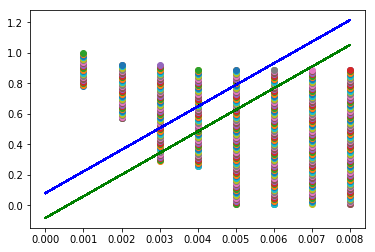

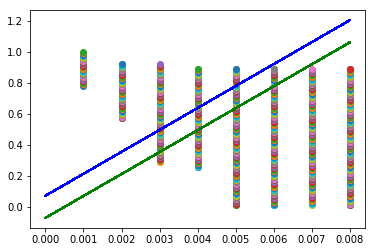

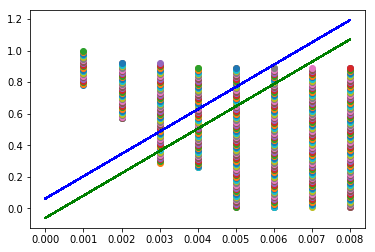

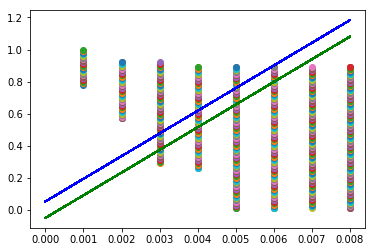

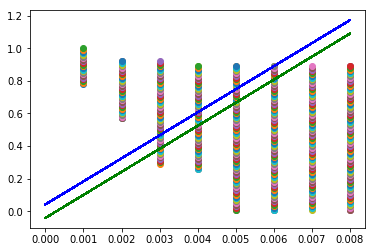

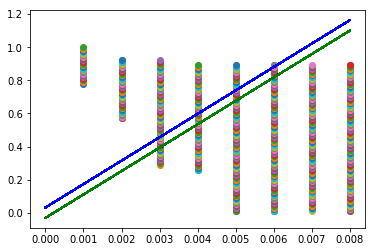

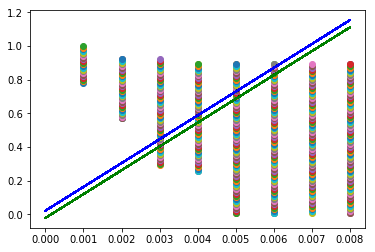

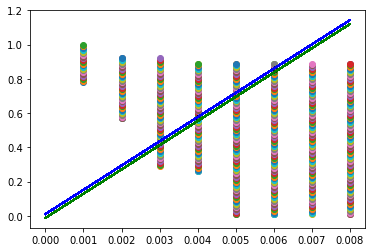

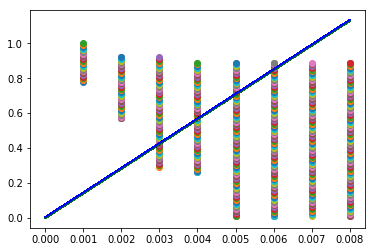

Encontrei uma dentro da reta! > 0.003 ,  0.42 ,  6.0
Encontrei uma dentro da reta! > 0.003 ,  0.43 ,  6.0
Encontrei uma dentro da reta! > 0.004 ,  0.56 ,  2.0
Encontrei uma dentro da reta! > 0.004 ,  0.57 ,  2.0
Encontrei uma dentro da reta! > 0.004 ,  0.56 ,  2.0
Encontrei uma dentro da reta! > 0.004 ,  0.57 ,  2.0
Encontrei uma dentro da reta! > 0.005 ,  0.7 ,  1.0
Encontrei uma dentro da reta! > 0.005 ,  0.71 ,  1.0
Encontrei uma dentro da reta! > 0.005 ,  0.7 ,  1.0
Encontrei uma dentro da reta! > 0.005 ,  0.71 ,  1.0
Encontrei uma dentro da reta! > 0.006 ,  0.85 ,  1.0
Encontrei uma dentro da reta! > 0.006 ,  0.85 ,  1.0
Encontrei uma dentro da reta! > 0.006 ,  0.85 ,  1.0


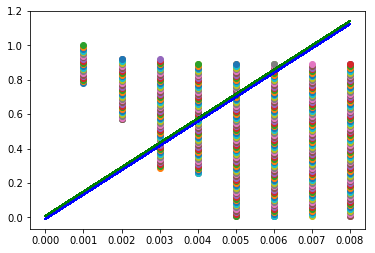

,Support,Confidence,NumberOfRules
0,0.003,0.42,6.0
1,0.003,0.43,6.0
2,0.004,0.56,2.0
3,0.004,0.57,2.0
4,0.004,0.56,2.0
5,0.004,0.57,2.0
6,0.005,0.70,1.0
7,0.005,0.71,1.0
8,0.005,0.70,1.0
9,0.005,0.71,1.0


In [10]:
middleValuesSessions = selecionarHighConfHighSupp(dfThresholdsSessions, maxRules)
middleValuesSessions